# Biomedical Semantic Search & Simplification Pipeline


## Summary
1. Required libraries
2. Data preprocessing

A. Encoder Part

3. Optimised encoder model configuration
4. Corpus encoding
5. Saving embeddings

B. Decoder Part

6. Decoder model configuration
7. Setting up user input for the chatbot

C. TF-IDF baseline

8. Evaluation
9. Prepare for evaluation
10. Metrics and results
11. Plot generation



### 1. Required libraries

In [1]:
# library installation
! pip install adapters transformers torch pandas tqdm numpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.9 MB/s eta 0:00:00


### 2. Data preprocessing
Steps to load data into Google Colab:

1. Go to your Google Drive.

2. Create a folder called `Project_NLP`.

3. Drag `OptimusPrime_for_GoogleColab.ipynb` notebook into it and doble-click on it.

4. The CRUCIAL step:

- In the top right corner, click on the small arrow next to 'Sign in' (or 'RAM/Disk').

- Select Change runtime type.

- Choose T4 GPU.

In [9]:
import os
import urllib.request
from google.colab import drive
from pathlib import Path
from tqdm import tqdm


# Connection to the drive
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Projct_NLP"

# Data repertory creation
local_path = "/content/data_temp"

# Uploading data files
files = [
    ("https://zenodo.org/records/14801641/files/relish_documents.tsv","relish_documents.tsv"),
    ("https://zenodo.org/records/14801641/files/relevance_matrix.tsv", "relevance_matrix.tsv")
]

def download_with_progress(url, destination_path):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=os.path.basename(destination_path)) as t:
        urllib.request.urlretrieve(url, filename=destination_path, reporthook=t.update_to)

for url, filename in files:
    destination_path = os.path.join(local_path, filename)
    if not os.path.exists(destination_path):
        download_with_progress(url, destination_path)
    else:
        print(f"{filename} already exists in{local_path}. Download ignored.")

# 4. Verification
print("Files :")
print(os.listdir(local_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


relish_documents.tsv: 0.00B [00:00, ?B/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/data_temp/relish_documents.tsv'

In [ ]:
# Connection to the drive
#drive.mount('/content/drive')
local_path = "Hands-on-NLP-Project"   # ⭐ Change your path


# Corpus loading
corpus_file = f"{local_path}/data/relish/relish_documents.tsv"  # ⭐ Change your path

print("Loading corpus...")
corpus_df = pd.read_csv(corpus_file, sep='\t')

# Inspection structure
print(f"✓ Corpus: {len(corpus_df)} articles")

# Standardise column names
if 'PMID' in corpus_df.columns:
    corpus_df.rename(columns={'PMID': 'pmid', 'Title': 'title', 'Abstract': 'abstract'},
                     inplace=True)

# Cleaning up the corpus of articles without abstracts
corpus_df = corpus_df.dropna(subset=['abstract'])
corpus_df['pmid'] = corpus_df['pmid'].astype(str)

print(f"After cleaning: {len(corpus_df)} articles")
print(f"Columns: {corpus_df.columns.tolist()}")


Loading corpus...
✓ Corpus: 163189 articles
After cleaning: 163189 articles
Columns: ['pmid', 'title', 'abstract']


## A. Encoder part
<a href="https://huggingface.co/allenai/specter2">Specter2</a> is chosen to vectorise the corpus It is capable of generating task specific embeddings for scientific tasks.

### 3. Optimised model configuration

In [3]:
import torch
from tqdm import tqdm
from transformers import AutoTokenizer
from adapters import AutoAdapterModel
from torch.cuda.amp import autocast

# Batch & device configuration
device = "cuda"
BATCH_SIZE = 128

print(f"device: {torch.cuda.get_device_name(0)}")

tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')
model = AutoAdapterModel.from_pretrained('allenai/specter2_base')
model.load_adapter("allenai/specter2", source="hf", load_as="proximity", set_active=True)

# Forces activation of the proximity adapter
model.set_active_adapters("proximity")

#Verification of the use of 'proximity' (a list containing 'proximity')
print(f"Active adapter?{model.active_adapters}")

model.to(device)

KeyboardInterrupt: 

### 4. Corpus encoding

In [16]:
import numpy as np

# Encoding function
def encode_papers_optimized(papers_list):
    # Préparation des inputs
    inputs = tokenizer(
        papers_list, # liste brute de textes
        padding=True, # tous les textes représentés par n tokens (nécessaire pour construire des matrices)
        truncation=True, # texte dépasse la limite définie de tokens, on coupe brutalement la fin
        return_tensors="pt", # retourne des tenseurs PyTorch, renvoie des listes bruts en objets utilisable par PyTorch
        max_length=512# la limite utilisée par le paramètre truncation
    ).to(device)

    # "autocast": performs calculations in 16-bit instead of 32-bit
    with torch.no_grad():
        with autocast():
            outputs = model(**inputs)

    return outputs.last_hidden_state[:, 0, :].cpu().numpy().astype(np.float32)

# encoding
texts_to_encode= (corpus_df['title'] + tokenizer.sep_token + corpus_df['abstract']).tolist()

embeddings = []
total_docs = len(texts_to_encode)

print(f"Encoding {total_docs} documents in batches of {BATCH_SIZE}...")

for i in tqdm(range(0, total_docs, BATCH_SIZE), unit="batch"):
    # Sélection du lot
    batch_texts = texts_to_encode[i : i + BATCH_SIZE]

    # Encodage
    emb = encode_papers_optimized(batch_texts)
    embeddings.append(emb)

# Embedding assembly
final_embeddings = np.vstack(embeddings)
print(f"Encoding finished ! Shape : {final_embeddings.shape}")

Encoding 163189 documents in batches of 128...


  0%|          | 0/1275 [00:00<?, ?batch/s]/tmp/ipython-input-1879055821.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 1275/1275 [28:46<00:00,  1.35s/batch]

Encoding finished ! Shape : (163189, 768)


### 5. Saving embeddings & corpus

In [18]:
DATA_PATH="/content/drive/MyDrive/Project_NLP"

np.save(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy", final_embeddings)

In [19]:
corpus_df.to_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")

*<p style="color: green;">THE DECODER PART IS INDEPENDENT OF THE ENCODER; IT WORKS IF THE CORPUS AND ITS EMBEDDINGS ARE LOADED FIRST.</p>*


## B. Decoder part
<a href="https://huggingface.co/Qwen/Qwen2.5-1.5B-Instruct"> Qwen 2.5</a> is selected as the text generator because it is easy to use locally and comprehensive.

### 6. Decoder configuration

In [20]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Configuration
model_id = "Qwen/Qwen2.5-1.5B-Instruct"

print(f"Chargement de {model_id} sur le Mac...")

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

# 4. Summary Function
def summarize_with_qwen(abstract_text):
    """
    Popularise a scientific abstract with Qwen 2.5
    """
    # Defining the role of the Chatbot
    messages = [
        {"role": "system", "content": "You are a helpful scientific assistant. Your goal is to summarize complex medical abstracts for a general audience (non-experts)."},
        {"role": "user", "content": f"Summarize this text in 4 simple sentences:\n\n{abstract_text}"}
    ]

    # Template output chatbot prompt
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    # Word generation
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=150,  # Longueur max du résumé
            temperature=0.7,     # Créativité (0.7 est équilibré)
            top_p=0.9            # Évite les phrases répétitives
        )

    # Decoding (The "prompt" part is removed to keep only the response)
    # generated_ids contient [Prompt + Réponse], on coupe le début
    input_len = model_inputs.input_ids.shape[1]
    response_ids = generated_ids[0][input_len:]

    response = tokenizer.decode(response_ids, skip_special_tokens=True)
    return response

# TEST
test_abstract = """
Acute myocardial infarction is a medical emergency comprising chest pain
and signs of ischemia on ECG. It is caused by the occlusion of a coronary artery.
Time is muscle, and rapid reperfusion is mandatory to save the patient.
"""

print("TEST SUMMARY")
summary = summarize_with_qwen(test_abstract)
print(summary)

Chargement de Qwen/Qwen2.5-1.5B-Instruct sur le Mac...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

TEST SUMMARY
Acute myocardial infarction is an urgent heart attack with chest pain and changes seen on an electrocardiogram. It's due to blocked blood flow in one of your heart's arteries. Quick treatment to restore blood flow is vital to save the heart muscle.


In [21]:
DATAFRAME= pd.read_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")
EMBEDDING= np.load(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy")

import numpy as np

def tranformer_retrieve_top_k(
    pmid_input,
    dataframe=DATAFRAME,
    embeddings=EMBEDDING,
    k=10
):
    pmid_input = str(pmid_input)
    matches = dataframe.index[dataframe["pmid"] == pmid_input].tolist()
    if len(matches) == 0:
        return f"PMID {pmid_input} not found in database."
    idx = matches[0]
    target_vec = embeddings[idx]
    scores = np.dot(embeddings, target_vec)
    sorted_indices = np.argsort(scores)[::-1]
    sorted_indices = sorted_indices[sorted_indices != idx]
    top_k_idx = sorted_indices[:k]
    results = dataframe.iloc[top_k_idx][["pmid", "title"]].copy()
    results["score"] = scores[top_k_idx]

    #return results.reset_index(drop=True)
    return results["pmid"].tolist()


### 7. Setting up user input for the chatbot

In [ ]:
import numpy as np
import pandas as pd

DATAFRAME= pd.read_pickle(f"{DATA_PATH}/corpus_Optimus.pkl")
EMBEDDING= np.load(f"{DATA_PATH}/relish_embeddings_specter_turbo.npy")

def moteur_recherche_medical(pmid_entre, dataframe=DATAFRAME, embeddings_matrice= EMBEDDING, k=10):
    # 1. Trouver l'index de l'article de départ

    pmid_cherche = str(pmid_entre)

    try:
        # On cherche la ligne où le PMID correspond
        index_article = dataframe.index[dataframe['pmid'] == pmid_cherche].tolist()[0]
    except IndexError:
        return "Sorry, this PMID is not currently in my article database.", []

    # 2. Récupérer son vecteur (Specter)
    vecteur_cible = embeddings_matrice[index_article].reshape(1, -1)

    # 3. Calculer la similarité (Produit scalaire) avec tous les autres
    # On compare le vecteur cible à toute la matrice d'un coup
    scores = np.dot(embeddings_matrice, vecteur_cible.T).flatten()

    # 4. Trier les scores et prendre les 10 meilleurs (on ignore le premier qui est lui-même)
    indices_voisins = np.argsort(scores)[::-1][1:k+1]

    # 5. Récupérer les données textuelles des voisins
    resultats = dataframe.iloc[indices_voisins]

    # 6. Le Décodeur : Résumer le texte du voisin le plus proche (le top 1)
    meilleur_match_abstract = resultats.iloc[0]['abstract']
    meilleur_match_titre = resultats.iloc[0]['title']

    print(f"L'article le plus proche est : {meilleur_match_titre}")

    # Appel à ta fonction Qwen (ton décodeur)
    resume_vulgarise = summarize_with_qwen(meilleur_match_abstract)

    return resume_vulgarise, resultats[['pmid', 'title']]

# --- EXEMPLE D'UTILISATION ---
resume, liste_articles = moteur_recherche_medical(27683064)
print(resume)

--- L'article le plus proche est : Sclerostin mediates bone response to mechanical unloading through antagonizing Wnt/beta-catenin signaling. ---
The research shows how mechanical stress affects bones. When bones don't get enough force from exercise or gravity, they start to lose calcium. Scientists discovered a protein called sclerostin that helps stop this happening. If you take away sclerostin from animals' bodies, their bones stay healthier when they're inactive. This could be important because it means there might be ways to help people who can't move much keep their bones strong without getting weaker over time.


## C. TFIDF Baseline

Df Volume:  (163189, 9399446)


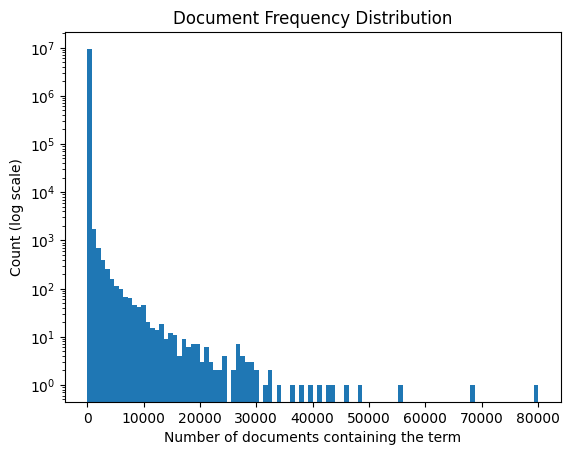

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt

corpus_df["text"] = corpus_df["title"] + " " + corpus_df["abstract"]

vectorizer = TfidfVectorizer(stop_words="english",ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus_df["text"])
print("Df Volume: ", X.shape)

# Zipf law
df = (X > 0).sum(axis=0).A1

plt.hist(df, bins=100, log=True)
plt.title("Document Frequency Distribution")
plt.xlabel("Number of documents containing the term")
plt.ylabel("Count (log scale)")
plt.show()

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def baseline_retrieve_top_k(query, k=5):
    # TFIDF quety
    q_vec = vectorizer.transform([query])
    # cosine similaruty
    scores = cosine_similarity(q_vec, X)[0]
    top_idx = np.argsort(scores)[-k:][::-1]
    return corpus_df.iloc[top_idx]["pmid"]

## 8. Evaluations:
1. Presicion, Mean prediction
2. Recall
3. F1
4. nDCG




In [7]:
corpus_df.columns

Index(['pmid', 'title', 'abstract', 'text'], dtype='object')

## 9. Preparation

In [8]:
# dict pimd2text
pmid_to_text = {}

for _, row in corpus_df.iterrows():
    pmid = row["pmid"]
    title = str(row["title"])
    abstract = str(row["abstract"])

    pmid_to_text[pmid] = {
        "title": title,
        "abstract": abstract
    }

print("Number of documents in pmid_to_text:", len(pmid_to_text))

Number of documents in pmid_to_text: 163189


In [ ]:
# query_dict:
DATA_PATH="Hands-on-NLP-Project"  # ⭐ Change your path
qrels_path = DATA_PATH+"/data/relish/relevance_matrix.tsv"  # ⭐ Change your path
qrels_df = pd.read_csv(qrels_path, sep='\t')

df = qrels_df.copy()
df.columns = [c.strip().lower() for c in df.columns]
df = df.dropna(subset=["pmid1", "pmid2", "relevance"])
df = df[df["pmid1"] != df["pmid2"]]

df = (
    df.groupby(["pmid1", "pmid2"], as_index=False)["relevance"]
    .max()
)

# =====  query_dict =====

# {
#   query_pmid: {
#       "docs": {doc_pmid: relevance_score, ...},
#       "relevant_docs": [pmid with relevance >=1],
#       "highly_relevant_docs": [pmid with relevance ==2]
#   }
# }

query_dict = {}
df["pmid1"] = df["pmid1"].astype(str)
df["pmid2"] = df["pmid2"].astype(str)

for _, row in df.iterrows():
    q = row["pmid1"]
    d = row["pmid2"]
    s = int(row["relevance"])

    if q not in query_dict:
        query_dict[q] = {
            "docs": {},
            "relevant_docs": [],
            "highly_relevant_docs": []
        }

    query_dict[q]["docs"][d] = s

    if s >= 1:
        query_dict[q]["relevant_docs"].append(d)

    if s == 2:
        query_dict[q]["highly_relevant_docs"].append(d)




def get_query_text(pmid, mode="full"):
    title = pmid_to_text[pmid]["title"]
    abstract = pmid_to_text[pmid]["abstract"]

    if mode == "title":
        return title
    elif mode == "abstract":
        return abstract
    elif mode == "full":
        return title + " " + abstract
    else:
        raise ValueError("Unknoe mode")


# Valide queries
K=5
N = 20
valid_queries = []
for q, data in query_dict.items():
    # At least 10 documents and at least 1 relevant>=1
    if len(data["docs"]) >= K and len(data["relevant_docs"]) > 0:
        valid_queries.append(q)
print("Valid queries:", len(valid_queries))


Valid queries: 3190


## 10. Evaluation metrics  
⭐：  
The code behind is used for baseline models evluation.  
Please Change your own retrival function "✅" here.

In [ ]:
#Presicion
def precision_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    """
    retrieved_pmids: list of pmids returned by retrieval
    query_pmid: the query pmid
    k: cutoff
    strict:
        False -> relevance >=1 considered relevant
        True  -> only relevance ==2 considered relevant
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    relevant_docs = query_dict[query_pmid]["docs"]
    hit = 0
    for pmid in retrieved_pmids:
        if pmid in relevant_docs:
            if strict:
                if relevant_docs[pmid] == 2:
                    hit += 1
            else:
                if relevant_docs[pmid] >= 1:
                    hit += 1
    return hit / k


# Mean precision
def mean_precision_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k)  #✅ Chaning your own retrieval function here
        p = precision_at_k(retrieved, q, k=k, strict=strict)
        scores.append(p)
    #return sum(scores) / len(scores)
    return scores



#==============================================================================
# Recall
def recall_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    """
    retrieved_pmids: list of pmids returned by retrieval
    query_pmid: the query pmid
    k: cutoff
    strict:
        False -> relevance >=1 considered relevant
        True  -> only relevance ==2 considered relevant
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    relevant_docs = query_dict[query_pmid]["docs"]
    if strict:
        total_relevant = sum(1 for s in relevant_docs.values() if s == 2)
    else:
        total_relevant = sum(1 for s in relevant_docs.values() if s >= 1)

    if total_relevant == 0:
        return 0.0
    hit = 0
    for pmid in retrieved_pmids:
        if pmid in relevant_docs:
            if strict:
                if relevant_docs[pmid] == 2:
                    hit += 1
            else:
                if relevant_docs[pmid] >= 1:
                    hit += 1
    return hit / total_relevant

# Mean recall
def mean_recall_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        r = recall_at_k(retrieved, q, k=k, strict=strict)
        scores.append(r)
    #return sum(scores) / len(scores)
    return scores


#===============================================================================
# F1
def f1_at_k(retrieved_pmids, query_pmid, k=10, strict=False):
    p = precision_at_k(retrieved_pmids, query_pmid, k=k, strict=strict)
    r = recall_at_k(retrieved_pmids, query_pmid, k=k, strict=strict)
    if p + r == 0:
        return 0.0
    return 2 * p * r / (p + r)

def mean_f1_at_k(valid_queries, k=10, strict=False):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        f1 = f1_at_k(retrieved, q, k=k, strict=strict)
        scores.append(f1)
    #return sum(scores) / len(scores)
    return scores



#========================================================================
# nDCG
import numpy as np

def dcg_at_k(retrieved_pmids, query_pmid, k=10, gain_scheme="exp2"):
    """
    gain_scheme:
      - "exp2": gain = 2^rel - 1
      - "linear": gain = rel
    """
    retrieved_pmids = retrieved_pmids[:k]
    if query_pmid not in query_dict:
        return 0.0
    rel_map = query_dict[query_pmid]["docs"]  # {pmid2: relevance(0/1/2)}
    dcg = 0.0
    for i, pmid in enumerate(retrieved_pmids, start=1):  # rank i from 1
        rel = rel_map.get(pmid, 0)

        if gain_scheme == "exp2":
            gain = (2 ** rel) - 1
        elif gain_scheme == "linear":
            gain = rel
        else:
            raise ValueError("gain_scheme must be 'exp2' or 'linear'")
        discount = np.log2(i + 1)
        dcg += gain / discount
    return dcg


def ndcg_at_k(retrieved_pmids, query_pmid, k=10, gain_scheme="exp2"):
    """
    nDCG@k = DCG@k / IDCG@k
    """
    if query_pmid not in query_dict:
        return 0.0
    rel_map = query_dict[query_pmid]["docs"]
    retrieved_pmids = retrieved_pmids[:k]
    # DCG of your ranking
    dcg = dcg_at_k(retrieved_pmids, query_pmid, k=k, gain_scheme=gain_scheme)
    # IDCG: ideal DCG by sorting all labeled docs by relevance desc
    ideal_rels = sorted(rel_map.values(), reverse=True)[:k]
    idcg = 0.0
    for i, rel in enumerate(ideal_rels, start=1):
        if gain_scheme == "exp2":
            gain = (2 ** rel) - 1
        else:  # linear
            gain = rel
        idcg += gain / np.log2(i + 1)
    if idcg == 0:
        return 0.0
    return dcg / idcg


def mean_ndcg_at_k(valid_queries, k=10, gain_scheme="exp2"):
    scores = []
    for q in valid_queries:
        query_text = get_query_text(q, mode="full")
        retrieved = baseline_retrieve_top_k(query_text, k=k) #✅ Chaning your own retrieval function here
        scores.append(ndcg_at_k(retrieved, q, k=k, gain_scheme=gain_scheme))
    #return float(np.mean(scores)) if scores else 0.0
    return scores








In [ ]:
# Save and print results
K = 10
p_at_10 = mean_precision_at_k(valid_queries[:500], k=K, strict=False)
print("Precision@10 (relevance>=1):", sum(p_at_10)/len(p_at_10))
p_at_10_strict = mean_precision_at_k(valid_queries[:500], k=K, strict=True)
print("Precision@10 (relevance==2):", sum(p_at_10_strict)/len(p_at_10_strict))
print("="*100)

r_at_10 = mean_recall_at_k(valid_queries[:500], k=K, strict=False)
print("Recall@10 (relevance>=1):", sum(r_at_10)/len(r_at_10))
r_at_10_strict = mean_recall_at_k(valid_queries[:500], k=K, strict=True)
print("Recall@10 (relevance==2):", sum(r_at_10_strict)/len(r_at_10_strict))
print("="*100)

f1_score_at_k = mean_f1_at_k(valid_queries[:500], k=K, strict=False)
print("F1@10 (relevance>=1):",sum(f1_score_at_k)/len(f1_score_at_k))
f1_score_at_k_strict = mean_f1_at_k(valid_queries[:500], k=K, strict=True)
print("F1@10 (relevance==2):",sum(f1_score_at_k_strict)/len(f1_score_at_k_strict))
print("="*100)

mean_ndcg_at_k = mean_ndcg_at_k(valid_queries[:500], k=K)
print("mean nDCG@10:", sum(mean_ndcg_at_k)/len(mean_ndcg_at_k))


## 11. Plot
This script generate automatically:   
Distribution  
Boxplot  

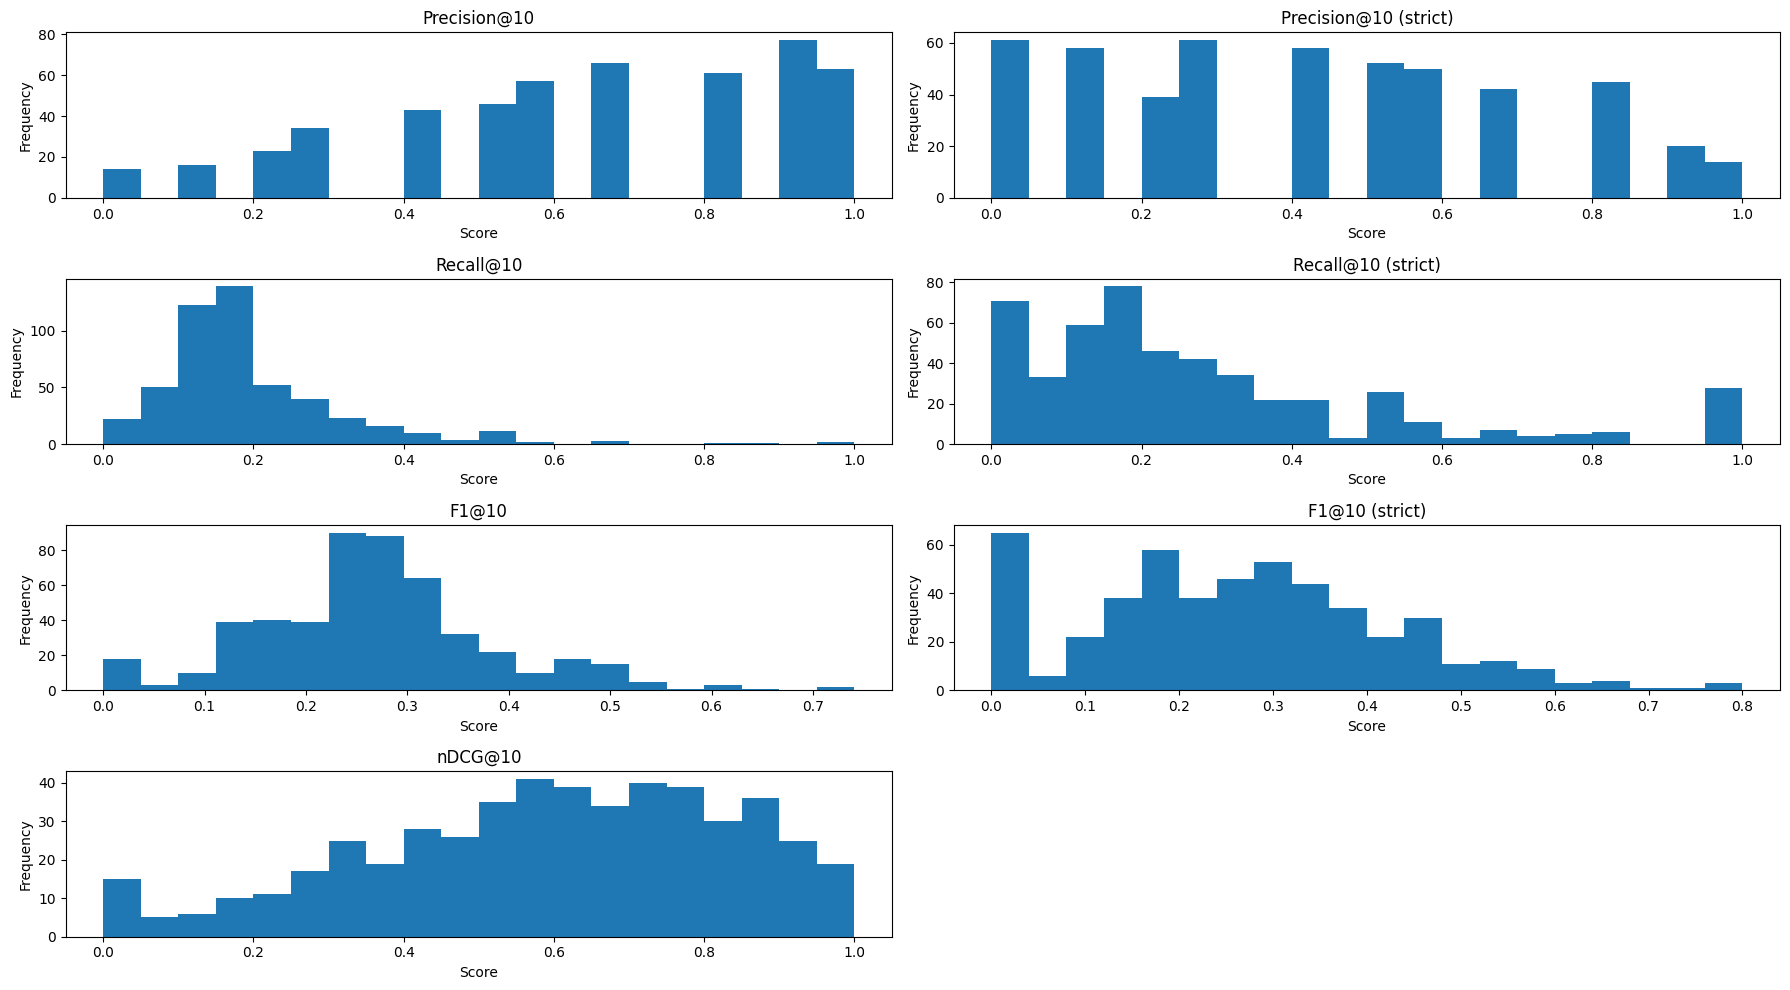

In [39]:
import matplotlib.pyplot as plt
metrics = {
    "Precision@10": p_at_10,
    "Precision@10 (strict)": p_at_10_strict,
    "Recall@10": r_at_10,
    "Recall@10 (strict)": r_at_10_strict,
    "F1@10": f1_score_at_k,
    "F1@10 (strict)": f1_score_at_k_strict,
    "nDCG@10": mean_ndcg_at_k
}

plt.figure(figsize=(18, 10))
for i, (name, values) in enumerate(metrics.items()):
    plt.subplot(4, 2, i+1)
    plt.hist(values, bins=20)
    plt.title(name)
    plt.xlabel("Score")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


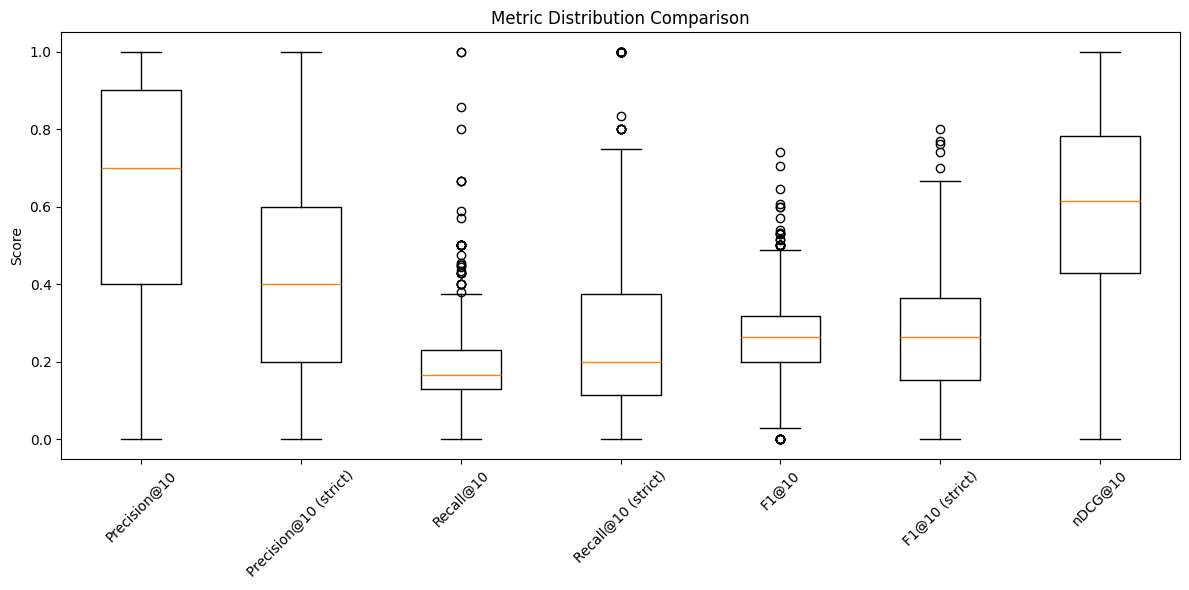

In [40]:
plt.figure(figsize=(12, 6))

plt.boxplot(metrics.values())
plt.xticks(range(1, len(metrics)+1), metrics.keys(), rotation=45)
plt.ylabel("Score")
plt.title("Metric Distribution Comparison")

plt.tight_layout()
plt.show()
